In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1) 載入資料集

In [2]:
url = 'https://github.com/1010code/iris-dnn-tensorflow/raw/master/data/Iris.csv'
s=requests.get(url).content
df_data=pd.read_csv(io.StringIO(s.decode('utf-8')))
df_data = df_data.drop(labels=['Id'],axis=1) # 移除Id
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## 2) 手動編碼
處理名目資料 (Nominal variables) - 資料前處理
依據特徵資料的特性，可以選擇手動編碼或自動編碼。

### 使用編碼時機?
進行深度學習時，神經網路只能處理數值資料。因此我們需要將所有非數字型態的特徵進行轉換。

ex:

|  Iris-setosa |  Iris-versicolor | Iris-virginica  |
|:---:|:---:|:---:|
|  1 | 2  | 3  |

In [3]:
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

#將編碼後的label map存至df_data['Species']中。
df_data['Class'] = df_data['Species'].map(label_map)

In [4]:
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Class
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


## 3) 檢查缺失值
使用 numpy 所提供的函式來檢查是否有 NA 缺失值，假設有缺失值使用dropna()來移除。使用的時機在於當只有少量的缺失值適用，若遇到有大量缺失值的情況，或是本身的資料量就很少的情況下建議可以透過機器學習的方法補值來預測缺失值。

```python
# 移除缺失值
train=train.dropna()
```

In [5]:
X = df_data.drop(labels=['Species','Class'],axis=1).values # 移除Species (因為字母不參與訓練)
# checked missing data
print("checked missing data(NAN mount):",len(np.where(np.isnan(X))[0]))

checked missing data(NAN mount): 0


## 4) 切割訓練集與測試集

In [6]:
from sklearn.model_selection import train_test_split
X=df_data.drop(labels=['Class','Species'],axis=1).values
y=df_data['Class'].values
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=.3 , random_state=42)

In [7]:
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (105, 4)
Testing data shape: (45, 4)


## 繪製決策邊界 Function

In [8]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


## PCA降維
將原先 iris 4個特徵降成2維，方便做視覺化。

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, iterated_power=1)
train_reduced = pca.fit_transform(X_train)

## 支持向量機 (Support Vector Machine, SVM) 模型
SVM 能夠透過 C 來達到 weight regularization 來限制模型的複雜度。除了這點我們還能透過 SVM 的 Kernel trick 的方式將資料做非線性轉換，常見的kernel 除了linear線性以外還有兩了非線性的Polynomial 高次方轉換以及Radial Basis Function:高斯轉換。

四種不同SVC分類器:
1. LinearSVC  (線性)
2. kernel='linear'  (線性)
3. kernel='poly'  (非線性)
4. kernel='rbf'  (非線性)

Methods:
- fit: 放入X、y進行模型擬合。
- predict: 預測並回傳預測類別。
- score: 預測成功的比例。
- predict_proba: 預測每個類別的機率值。

### LinearSVC
Parameters:
- C: 限制模型的複雜度，防止過度擬合。
- max_iter: 最大迭代次數，預設1000。

Text(0.5, 1.0, 'LinearSVC (linear kernel)\nAccuracy:0.95')

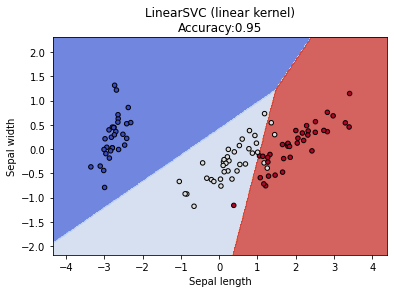

In [10]:
from sklearn import svm

# 建立SVM模型
linearSvcModel=svm.LinearSVC(C=1, max_iter=10000)
# 使用訓練資料訓練模型
linearSvcModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted=linearSvcModel.predict(train_reduced)

accuracy = linearSvcModel.score(train_reduced, y_train)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, linearSvcModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('LinearSVC (linear kernel)'+ '\n' + 'Accuracy:%.2f'%accuracy)

### kernel='linear'
Parameters:
- C: 限制模型的複雜度，防止過度擬合。
- kernel: 此範例採用線性。

Text(0.5, 1.0, 'SVC with linear kernel\nAccuracy:0.96')

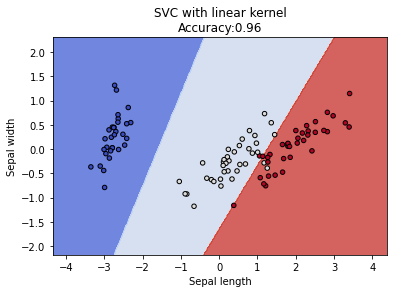

In [11]:
from sklearn import svm

svcModel=svm.SVC(kernel='linear', C=1)
svcModel.fit(train_reduced, y_train)
accuracy = svcModel.score(train_reduced, y_train)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, svcModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with linear kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)

### kernel='poly'
Parameters:
- C: 限制模型的複雜度，防止過度擬合。
- kernel: 此範例採用 Polynomial 高次方轉換。
- degree: 增加模型複雜度，3 代表轉換到三次空間進行分類。
- gamma: 數值越大越能做複雜的分類邊界。

Text(0.5, 1.0, 'SVC with polynomial (degree 3) kernel\nAccuracy:0.95')

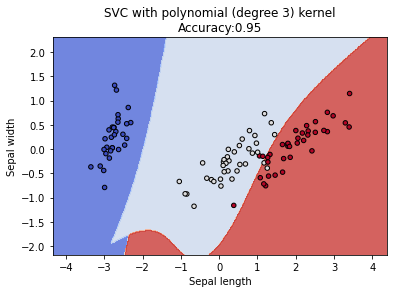

In [12]:
from sklearn import svm

polyModel=svm.SVC(kernel='poly', degree=3, gamma='auto', C=1)
polyModel.fit(train_reduced, y_train)
accuracy = polyModel.score(train_reduced, y_train)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, polyModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with polynomial (degree 3) kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)

### kernel='rbf'
Parameters:
- C: 限制模型的複雜度，防止過度擬合。
- kernel: 此範例採用 Radial Basis Function 高斯轉換。
- gamma: 數值越大越能做複雜的分類邊界

accuracy:  0.9523809523809523


Text(0.5, 1.0, 'SVC with RBF kernel\nAccuracy:0.95')

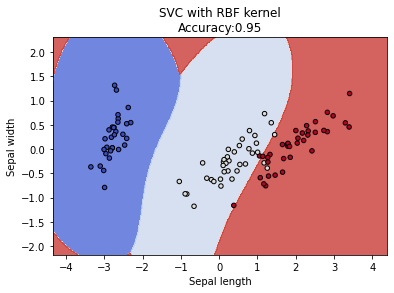

In [13]:
from sklearn import svm

rbfModel=svm.SVC(kernel='rbf', gamma=0.7, C=1)
rbfModel.fit(train_reduced, y_train)

accuracy = rbfModel.score(train_reduced, y_train)
print('accuracy: ', accuracy)

X0, X1 = train_reduced[:, 0], train_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(plt, rbfModel, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('SVC with RBF kernel'+ '\n' + 'Accuracy:%.2f'%accuracy)

## 比較不同的 Kernel 

![](https://i.imgur.com/IpPcsF6.png)